In [1]:
import pandas as pd
import numpy as np
import pywt
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
df = pd.read_pickle('data.pkl')
df.head()

,Date(yyyy/mm/dd),Time(UTC),Time,Lat.,Lon.,Depth,Mag.,unit,wave
0,1970/01/01,00:00:00.0,.0,36.39,50.48,0,5.4,Ms,"[1.2131383950913538e-07, 9.23729787272866e-07,..."
1,1924/09/27,10:12:00.0,.0,37,53,16,4.9,Ms,"[5.066815904206827e-07, 2.8382285884963117e-07..."
2,1927/07/22,03:55:00.0,.0,34.72,53.64,0,6.9,mb,"[5.642597714013678e-10, 2.41649599776002e-05, ..."
3,1927/10/31,06:23:00.0,.0,36.5,49,0,4.0,Ms,"[5.304413251018102e-10, 2.616176747010001e-07,..."
4,1930/10/02,15:32:00.0,.0,35.76,51.99,0,5.2,Ms,"[6.242788821199316e-09, 1.0843447797633704e-07..."


In [3]:
df['fMag'] = df['Mag.']

In [4]:
df['Mag.'] = df['Mag.'].apply(lambda x :int(x) if (x-int(x)) < 0.5 else int(x)+1)

In [5]:
# drop the columns that are not needed
df.drop(columns=['Date(yyyy/mm/dd)', 'Time(UTC)', 'Time', 'unit'], inplace=True)
df.dropna(inplace=True)
df.head()

,Lat.,Lon.,Depth,Mag.,wave,fMag
0,36.39,50.48,0,5,"[1.2131383950913538e-07, 9.23729787272866e-07,...",5.4
1,37,53,16,5,"[5.066815904206827e-07, 2.8382285884963117e-07...",4.9
2,34.72,53.64,0,7,"[5.642597714013678e-10, 2.41649599776002e-05, ...",6.9
3,36.5,49,0,4,"[5.304413251018102e-10, 2.616176747010001e-07,...",4.0
4,35.76,51.99,0,5,"[6.242788821199316e-09, 1.0843447797633704e-07...",5.2


In [6]:
# train test split
train, test = train_test_split(df, test_size=0.3, random_state=38)
print('train data shape: ', train.shape)
print('test data shape:  ', test.shape)

train data shape:  (2228, 6)
test data shape:   (955, 6)


In [7]:
train

,Lat.,Lon.,Depth,Mag.,wave,fMag
1493,35.55,50,17,4,"[2.487142243113722e-10, 3.828524271664179e-06,...",3.7
3199,35.62,52.59,10,3,"[3.70917635409502e-07, 2.6136423801894964e-11,...",2.8
219,35.119,52.228,6,5,"[1.2815227870639712e-09, 6.745758973383139e-08...",4.7
1754,35.84,51.01,14,2,"[1.3196588031738518e-06, 1.088811354360244e-06...",1.7
2486,35.67,49.81,14,2,"[2.4414161005320315e-10, 1.3631383948494898e-0...",1.9
...,...,...,...,...,...,...
1379,35.79,48.87,14,3,"[1.777240616456157e-05, 1.1377208577241893e-06...",3.0
3045,36.965,50.761,14,2,"[8.765657505004969e-06, 4.168617306891196e-09,...",2.2
413,33.504,50.994,33,4,"[8.813882968160395e-09, 8.721036973403467e-06,...",4.0
1588,34.42,49.79,12,4,"[1.1105977102815655e-08, 1.043865090141117e-06...",4.0


In [8]:
# wave column to matrix/data frame
train_wave_mat = []
for i in train['wave']:
    i = i.tolist()
    train_wave_mat.append(i)
test_wave_mat = []
for i in test['wave']:
    i = i.tolist()
    test_wave_mat.append(i)


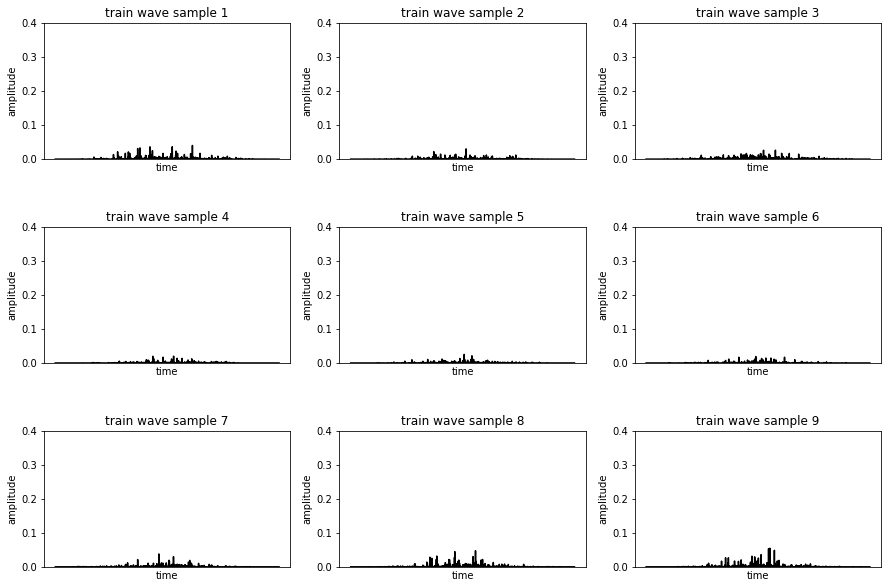

In [9]:
# plot some train wave samples
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.2)
n = 0
for i in range(3):
    for j in range(3):
        axs[i,j].plot(train_wave_mat[n], color='black')
        axs[i,j].set_title('train wave sample ' + str(n+1))
        axs[i,j].set_xlabel('time')
        axs[i,j].set_ylabel('amplitude')
        axs[i,j].set_ylim(0, 0.4)
        axs[i,j].set_xticks([])
        n += 1

In [10]:
# extract labels
train_labels_mat = train['Mag.'].tolist()
test_labels_mat = test['Mag.'].tolist()

In [11]:
# define functions to extract features

def features(data, labels, waveletname):
    features_list = []
    list_unique_labels = list(set(labels))
    list_labels = [list_unique_labels.index(elem) for elem in labels]
    for signal in data:
        coeff_list = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in coeff_list:
            features += get_features(coeff)
        features_list.append(features)
    return features_list, list_labels

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def calculate_entropy(list_values):
    from collections import Counter
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=sp.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

In [12]:
# extract features / wavelet transform
X_train, y_train = features(train_wave_mat, train_labels_mat, 'db4')
X_test, y_test = features(test_wave_mat, test_labels_mat, 'db4')

In [13]:
# preparing for plot wavelet transform amplitude
trainset = np.array(X_train)
testset = np.array(X_test)
train_magitude = np.array(train['fMag'])
test_magitude = np.array(test['fMag'])
train_wavelet_amplitude = trainset.max(axis=1) - trainset.min(axis=1)
test_wavelet_amplitude = testset.max(axis=1) - testset.min(axis=1)

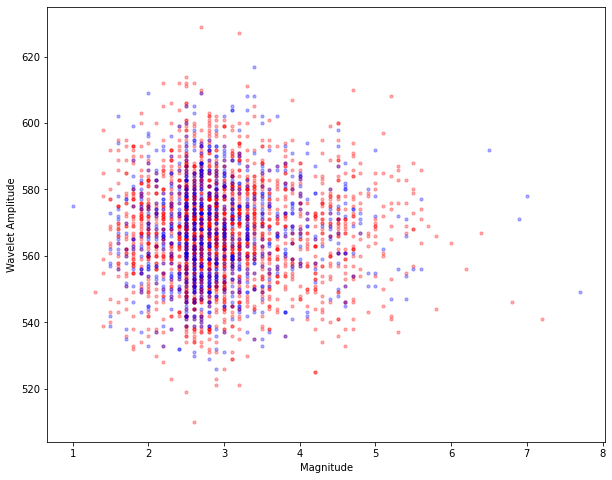

In [14]:
# plot wavelet transform amplitude
size = 10
alpha = 0.3
plt.figure(figsize=(10,8))
plt.scatter(train_magitude, train_wavelet_amplitude, s=size, c='r', alpha=alpha)
plt.scatter(test_magitude, test_wavelet_amplitude, s=size, c='b', alpha=alpha)
plt.ylabel('Wavelet Amplitude')
plt.xlabel('Magnitude')
plt.show()

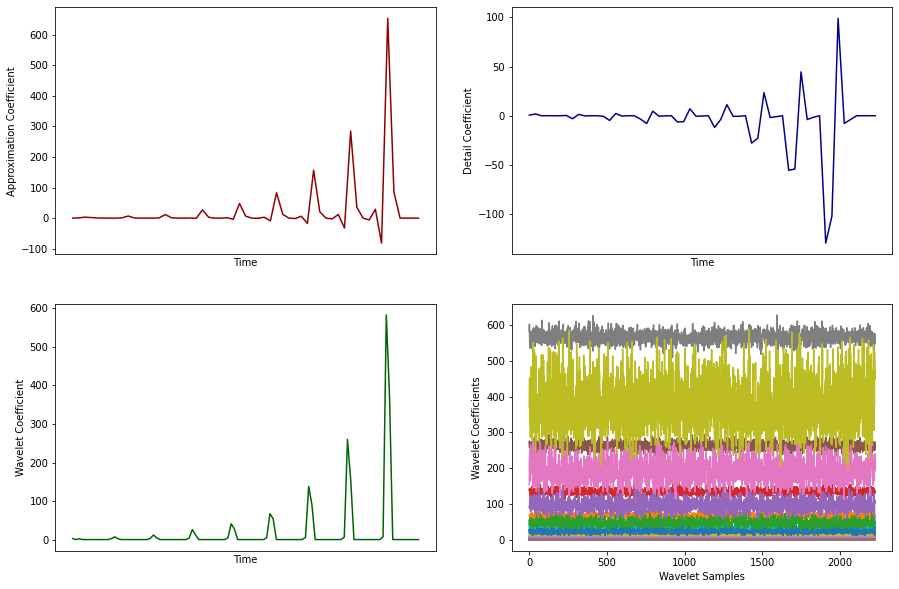

In [16]:
# plot coefficients
from scipy import signal
a = pywt.wavedec(X_train, 'db4', mode='sym', level=None)
(cA, cD) = pywt.dwt(X_train, 'db4', mode='sym')
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].plot(cA[0], color='darkred')
axs[0][0].set_xlabel('Time')
axs[0][0].set_ylabel('Approximation Coefficient')
axs[0][0].set_xticks([])
axs[0][1].plot(cD[0], color='darkblue')
axs[0][1].set_xlabel('Time')
axs[0][1].set_ylabel('Detail Coefficient')
axs[0][1].set_xticks([])
axs[1][0].plot(X_train[0], color='darkgreen')
axs[1][0].set_xlabel('Time')
axs[1][0].set_ylabel('Wavelet Coefficient')
axs[1][0].set_xticks([])
axs[1][1].plot(X_train[:])
axs[1][1].set_xlabel('Wavelet Samples')
axs[1][1].set_ylabel('Wavelet Coefficients')

plt.show()

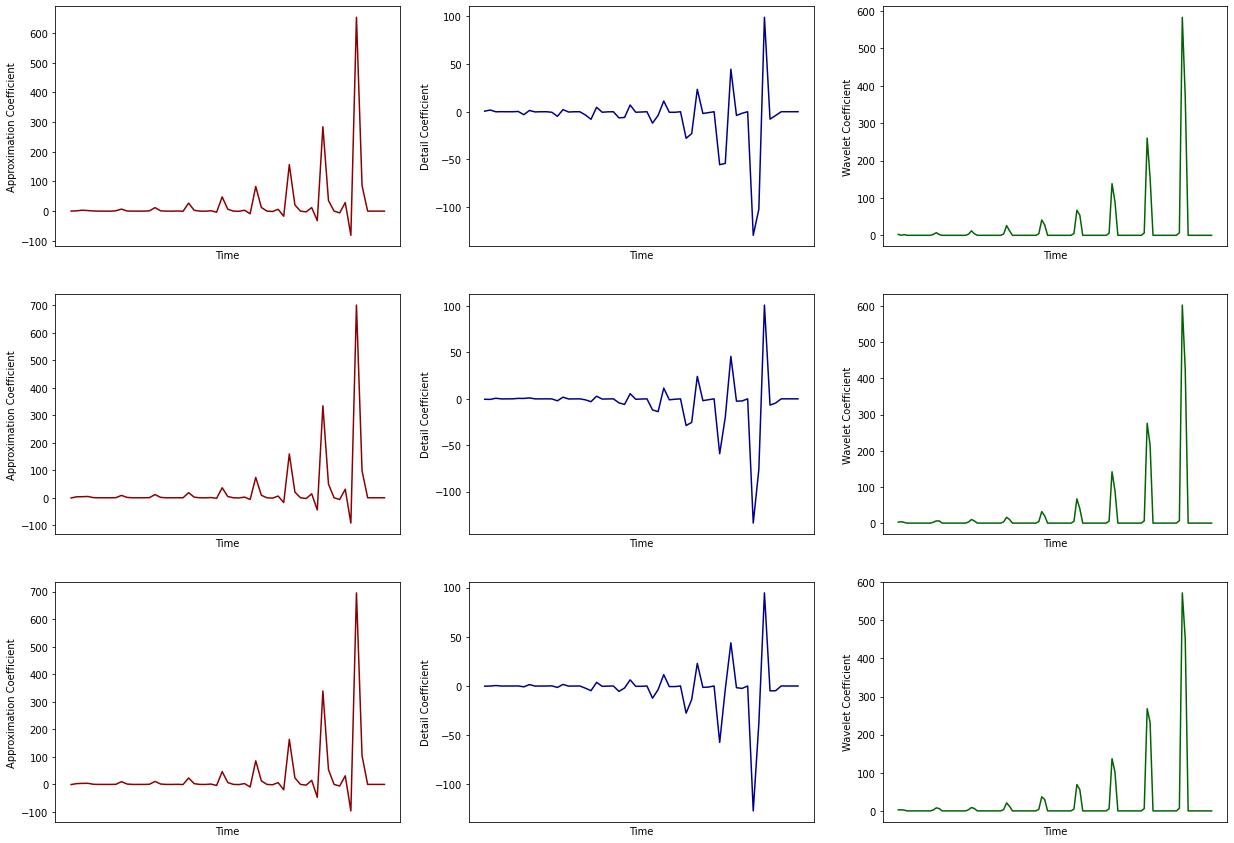

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(21, 15))
for i in range(3):
    axs[i][0].plot(cA[i], color='darkred')
    axs[i][0].set_xlabel('Time')
    axs[i][0].set_ylabel('Approximation Coefficient')
    axs[i][0].set_xticks([])
    axs[i][1].plot(cD[i], color='darkblue')
    axs[i][1].set_xlabel('Time')
    axs[i][1].set_ylabel('Detail Coefficient')
    axs[i][1].set_xticks([])
    axs[i][2].plot(X_train[i], color='darkgreen')
    axs[i][2].set_xlabel('Time')
    axs[i][2].set_ylabel('Wavelet Coefficient')
    axs[i][2].set_xticks([])

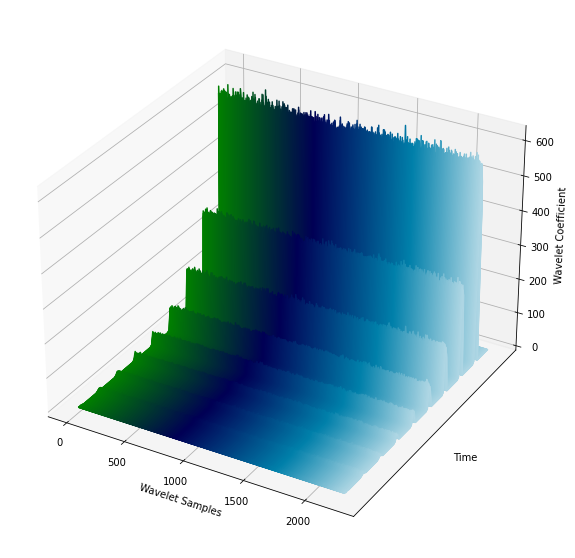

In [21]:
import matplotlib as mpl
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
x = np.linspace(0,108,108)
y = np.asarray(X_train)
z = range(len(y))
cmap = mpl.cm.get_cmap('ocean')
for i in z:
    ax.plot(x,y[i],zs=i,zdir='x', color=cmap(i/2500))
ax.set_xlabel('Wavelet Samples')
ax.set_ylabel('Time')
ax.set_yticks([])
ax.set_zlabel('Wavelet Coefficient')
plt.show()

In [156]:
# all data as np array
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# od_train = train.to_numpy()
# od_test = test.to_numpy()

In [157]:
# add other feutures to train data
# X_train = np.c_[od_train, X_train]
# X_test = np.c_[od_test, X_test]

In [22]:
# create pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [24]:
# fit the model
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [25]:
# predict test
y_pred = clf.predict(X_test)

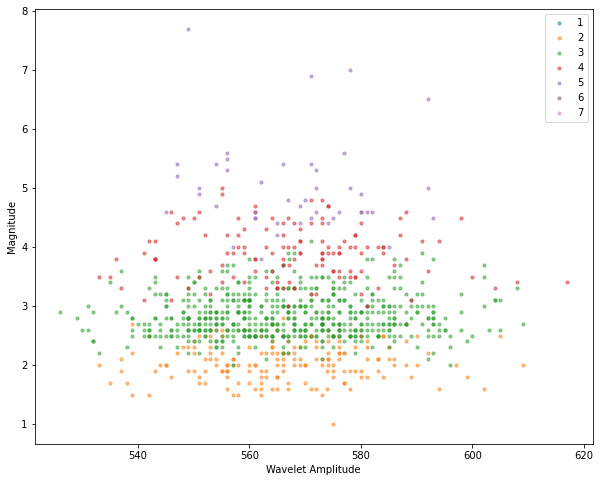

In [26]:
# scatter plot
labels = clf.named_steps['svc'].classes_
size = 10
alpha = 0.5
colors = range(len(labels))
plt.figure(figsize=(10,8))
for i in range(len(labels)):
    plt.scatter(test_wavelet_amplitude[y_pred == i], test_magitude[y_pred == i], label=labels[i]+1, s=size, alpha=alpha)
    plt.xlabel('Wavelet Amplitude')
    plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [27]:
# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('accuracy: ', accuracy)

accuracy:  0.8157068062827225


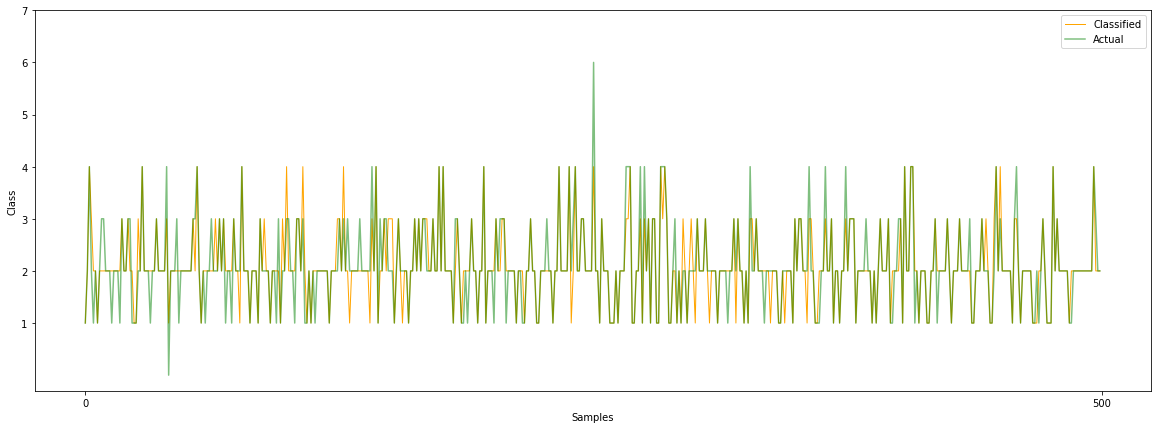

In [28]:
# plot pred/actual class
plt.figure(figsize=(20,7))
plt.plot(y_pred[:500], color='orange', label='Classified', linewidth=1, alpha=1)
plt.plot(y_test[:500], color='green', label='Actual', alpha=0.5)
plt.xlabel('Samples')
plt.ylabel('Class')
plt.xticks([0,500])
plt.yticks([1,2,3,4,5,6,7])
plt.legend()
plt.show()

In [29]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix: ', cm)

confusion matrix:  [[  0   1   0   0   0   0   0   0]
 [  0 150  50   0   0   0   0   0]
 [  0  25 508  25   0   0   0   0]
 [  0   0  42  90   7   0   0   0]
 [  0   0   0  19  31   0   0   0]
 [  0   0   0   0   3   0   0   0]
 [  0   0   0   0   3   0   0   0]
 [  0   0   0   0   1   0   0   0]]


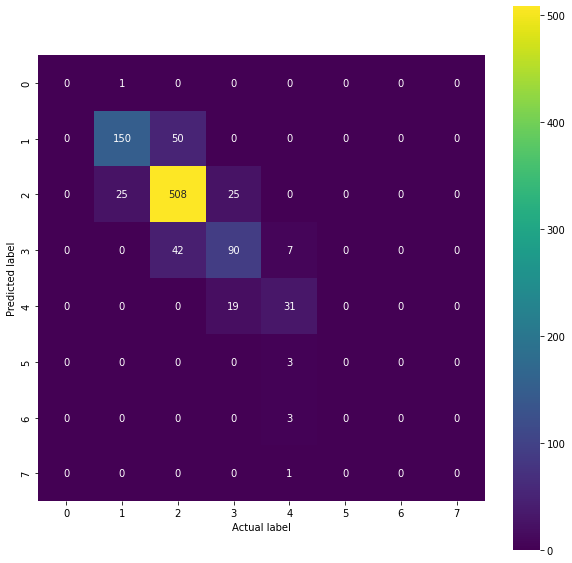

In [30]:
# plot confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, cmap='viridis', fmt='d')
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.show()